Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)
* Taylon L C Martins (RA: 177.379)

# Lista 02

## Tarefa

Abordar o problema de reconhecimento de atividades humanas (HAR, do inglês _human activity recognition_) a partir de informações capturadas por sensores de smartphones.

Utilizar regressão logística e kNN, com os dados pré-processados e dados brutos.

**Dataset**

* [UCI HAR](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)

* Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import balanced_accuracy_score
# from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss
# from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import MinMaxScaler



import numpy as np

import joblib
# from matplotlib.dates import DateFormatter
# from matplotlib.patches import Patch

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import cross_val_score

# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import root_mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error

In [5]:
RERUN = False

## Read Preprocessed Dataset

In [6]:
def read_csv_(path, sep=r"\s+|;|:|,"):
    return pd.read_csv(
        filepath_or_buffer=path,
        sep=sep,
        engine='python',
        header=None)

In [7]:
df_labels = read_csv_(r'..\Lista02\UCI_HAR_Dataset\activity_labels.txt')
df_labels.drop(0, axis=1, inplace=True)
df_labels = df_labels.rename(columns={1: 'activity'})

def get_label_name(i):
    return df_labels['activity'][i-1]

In [8]:
df_features = read_csv_(r'..\Lista02\UCI_HAR_Dataset\features.txt', sep=r"\s+")
df_features.drop(0, axis=1, inplace=True)
df_features = df_features.rename(columns={1: 'feature'})

def get_feature_name(i):
    return df_features['feature'][i]

In [9]:
X = read_csv_(r'..\Lista02\UCI_HAR_Dataset\train\X_train.txt')
y = read_csv_(r'..\Lista02\UCI_HAR_Dataset\train\y_train.txt')
X_test = read_csv_(r'..\Lista02\UCI_HAR_Dataset\test\X_test.txt')
y_test = read_csv_(r'..\Lista02\UCI_HAR_Dataset\test\y_test.txt')

In [10]:
print('Train data')
print(f'  X: {X.shape}')
print(f'  y: {y.shape}')
print('Test data')
print(f'  X: {X_test.shape}')
print(f'  y: {y_test.shape}')

Train data
  X: (7352, 561)
  y: (7352, 1)
Test data
  X: (2947, 561)
  y: (2947, 1)


In [41]:
train_labels = y[0].unique()
train_labels.sort()
train_label_count = [len(y[0][y[0]==label]) for label in train_labels]

test_labels = y_test[0].unique()
test_labels.sort()
test_label_count = [len(y_test[0][y_test[0]==label]) for label in test_labels]

print(f'Labels are the same: {np.all(test_labels == train_labels)}')

print(f'Smallest/Largest train labels: {min(train_label_count)/max(train_label_count)*100:0.2f}%')

Labels are the same: True
Smallest/Largest train labels: 70.08%


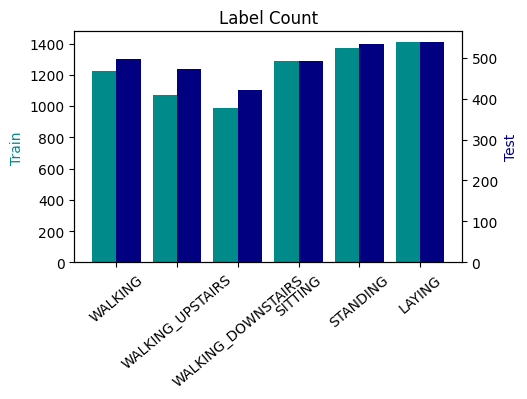

In [12]:
fig, ax1 = plt.subplots(figsize=(5, 3))
labels = [get_label_name(i) for i in train_labels]

ax1.bar(np.arange(len(labels)) - 0.2, train_label_count, color='darkcyan', width=0.4, align='center')
ax1.set_ylabel('Train', color='darkcyan')

ax2 = ax1.twinx()
ax2.bar(np.arange(len(labels)) + 0.2, test_label_count, color='navy', width=0.4, align='center')
ax2.set_ylabel('Test', color='navy')

plt.title('Label Count')
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation=40)
plt.savefig('report/png/A_LabelCount.png', bbox_inches='tight')
plt.show()

Aparentemente o desbalanço entre as classes não é significativo (menor classe tem 30% menos elementos que a maior classe), mas existe. De toda forma será utilizada a acurácia balanceada como métrica da qualidade do classificador (média dos _recalls_ de cada classe).

In [13]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


Dados estão normalizados em [-1;1].

## Logistic Regression

Opções utilizadas:

* Validação cruzada estratificada em 5 pastas.
* Normalização $l_2$ ($\frac{1}{2} ||w||_2^2$), com otimização do seu inverso ($c = \frac{1}{l_2}$)
* Função objetivo da otimização: acurácia balanceada.
* Estratégia: multinomial (entropia cruzada).

Fontes: 

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [14]:
if RERUN:
    logistic = LogisticRegressionCV(
        cv=5,
        solver='saga',
        scoring='balanced_accuracy',
        random_state=42,
        n_jobs=-1)
    logistic.fit(X, y[0].values)

    _ = joblib.dump(logistic, 'logistic_model.sav')
else:
    logistic = joblib.load('logistic_model.sav')

C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: Convergen

In [15]:
print(f'Normalization coefficients l2:\n {[np.round(1/c,4) for c in logistic.C_]}')

Normalization coefficients l2:
 [0.3594, 0.3594, 0.3594, 0.3594, 0.3594, 0.3594]


In [69]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column) for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")

def model_summary(model, X_test, y_test, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [('Class','Recall','F1 score')]
        balanced_accuracy = recall_score(y_test, y_pred, average='macro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        results.append(('All',
                        f'{balanced_accuracy:0.4f}',
                        f'{f1_macro:0.4f}'))

        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        for label,r,f1 in zip(labels,recall, f1):
            results.append((label,
                            f'{r:0.4f}',
                            f'{f1:0.4f}'))

        print_table(results, horizontal_lines=[1,2])

    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
                confusion_matrix=conf_matrix,
                display_labels=labels)

        fig, ax = plt.subplots(figsize=(8, 6))
        plt.title(f'{description} Confusion Matrix')
        conf_matrix_disp.plot(ax=ax, xticks_rotation=40)  # You can adjust rotation as needed
        plt.savefig(f'report/png/{filename}', bbox_inches='tight')
        plt.show()

    y_pred = model.predict(X_test)
    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(y_pred, y_test, labels, description, filename)

| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.9598 | 0.9606   |
------------------------------------------
| WALKING            | 0.9940 | 0.9686   |
| WALKING_UPSTAIRS   | 0.9427 | 0.9569   |
| WALKING_DOWNSTAIRS | 0.9690 | 0.9795   |
| SITTING            | 0.8717 | 0.9214   |
| STANDING           | 0.9812 | 0.9372   |
| LAYING             | 1.0000 | 1.0000   |


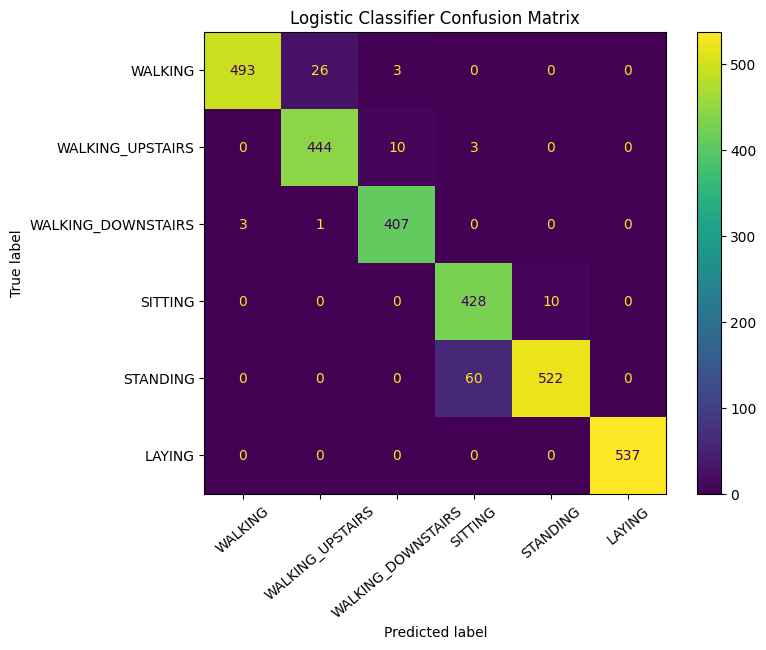

In [70]:
model_summary(logistic, X_test, y_test, labels,
              'Logistic Classifier', 'A_Logistic_CM.png')

O F1-score também seria uma boa escolha para avaliar a qualidade dos classificadores.

Em geral o classificador tem um bom desempenho. Ao analisar por classe, fica claro que o desempenho não é uniforme. A classe 'SITTING' tem um valor de recall bem mais baixo que as demais.

## kNN

Foi feita uma busca em grade para encontrar os melhores parâmetros para o classificador de k-vizinhos mais próximos. A partir desta primeira busca foi feita uma segunda otimização de hiperparâmetros, usando um número maior de pastas na validação cruzada.

In [140]:
if RERUN:
    param_grid = {
        'n_neighbors': np.arange(3, 6),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    }
    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=3,
        scoring='balanced_accuracy',
        n_jobs=-1)
    grid_search.fit(X, y[0].values)
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [72]:
def do_CV(X, y, model):
    skf = StratifiedKFold(n_splits=5) #, shuffle=True, random_state=42)
    recall = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        recall.append(recall_score(y_test, y_pred, average='macro'))
    return np.mean(recall)

def do_kNN_CV(X, y, n_neighbors, verbose=False):
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights = 'distance',
        p=1,
        n_jobs=-1)
    balanced_acc = do_CV(X,y,knn)
    if verbose:
        print(f'k={n_neighbors}  recall={balanced_acc:0.4f}')

In [73]:
knn_results = []
for i in range(1,21):
    knn_results.append(do_kNN_CV(X, y[0], i, True))

k=1  recall=0.8854
k=2  recall=0.8854
k=3  recall=0.8947
k=4  recall=0.8953
k=5  recall=0.9025
k=6  recall=0.9022
k=7  recall=0.9033
k=8  recall=0.9034
k=9  recall=0.9046
k=10  recall=0.9068
k=11  recall=0.9057
k=12  recall=0.9057
k=13  recall=0.9069
k=14  recall=0.9066
k=15  recall=0.9052
k=16  recall=0.9048
k=17  recall=0.9045
k=18  recall=0.9050
k=19  recall=0.9048
k=20  recall=0.9055


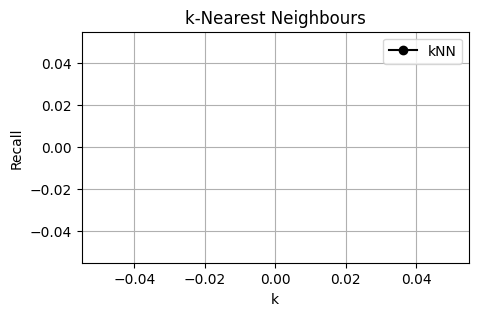

In [82]:
plt.figure(figsize=(5, 3))
plt.plot(range(1,21), knn_results, color='black', marker='o', label='kNN')

plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k-Nearest Neighbours')
plt.grid(True)
plt.legend()
plt.savefig('report/png/A_kNN_bestK.png', bbox_inches='tight')
plt.show()

In [67]:
best_k = knn_results.index(max(knn_results))+1
print(f'Best k={best_k}')

knn = KNeighborsClassifier(
        n_neighbors=best_k,
        weights = 'distance',
        p=1,
        n_jobs=-1)
knn.fit(X, y[0])
y_pred = knn.predict(X_test)
knn_accuracy = recall_score(y_test, y_pred, average='macro')
print(f'Balanced accuracy={knn_accuracy:0.4f}')

Best k=13
Balanced accuracy=0.9141557156557422


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.9142 | 0.9161   |
------------------------------------------
| WALKING            | 0.9819 | 0.9206   |
| WALKING_UPSTAIRS   | 0.9151 | 0.8970   |
| WALKING_DOWNSTAIRS | 0.7857 | 0.8719   |
| SITTING            | 0.8248 | 0.8921   |
| STANDING           | 0.9774 | 0.9163   |
| LAYING             | 1.0000 | 0.9991   |


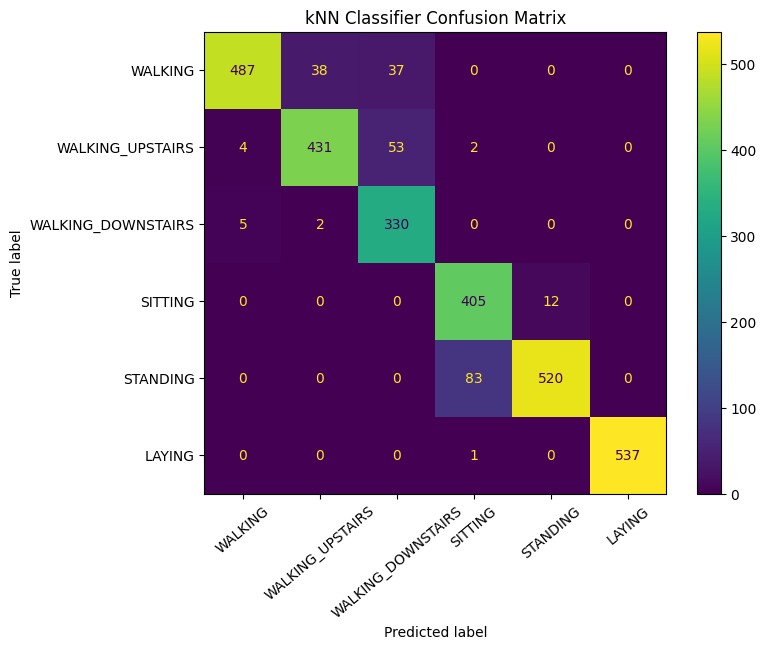

In [71]:
model_summary(knn, X_test, y_test, labels,
              'kNN Classifier', 'A_kNN_CM.png')

Resultado do classificador kNN ficou abaixo do logístico. Os valores de acurácia balanceada já indicavam este comportamento. Nesta primeira tentativa apenas o valor de K, p e critério de pesos foram avaliados. Uma nova tentativa será feita aplicando normalização [0,1] a todos os dados.

In [75]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=X.columns)

In [79]:
knn_results2 = []
for i in range(1,21):
    knn_results2.append(do_kNN_CV(X_scaled, y[0], i, True))

k=1  recall=0.8878
k=2  recall=0.8878
k=3  recall=0.8971
k=4  recall=0.8984
k=5  recall=0.9036
k=6  recall=0.9035
k=7  recall=0.9042
k=8  recall=0.9034
k=9  recall=0.9040
k=10  recall=0.9048
k=11  recall=0.9067
k=12  recall=0.9065
k=13  recall=0.9077
k=14  recall=0.9052
k=15  recall=0.9051
k=16  recall=0.9051
k=17  recall=0.9059
k=18  recall=0.9062
k=19  recall=0.9066
k=20  recall=0.9058


In [81]:
knn_results

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

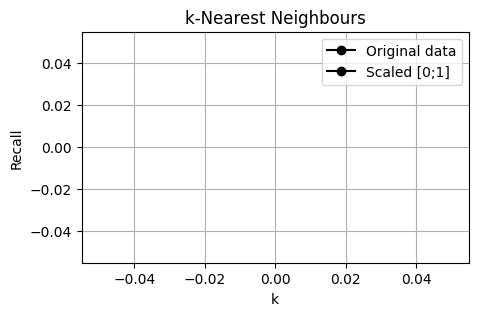

In [80]:
plt.figure(figsize=(5, 3))
plt.plot(range(1,21), knn_results, color='black', marker='o', label='Original data')
plt.plot(range(1,21), knn_results2, color='black', marker='o', label='Scaled [0;1]')

plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k-Nearest Neighbours')
plt.grid(True)
plt.legend()
plt.savefig('report/png/A_kNN_bestK2.png', bbox_inches='tight')
plt.show()

Uma segunda etapa na busca por um classificador de melhores resultados é testando os parâmetros de entrada. É feita uma otimização _gulosa_ dos parâmetros que devem ser utilizados na construção do classificador de k-vizinhos mais próximos.